In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geovoronoi import coords_to_points, points_to_coords, voronoi_regions_from_coords, calculate_polygon_areas,assign_points_to_voronoi_polygons
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
pd.options.mode.chained_assignment = None
import matplotlib.style
import matplotlib as mpl
import logging
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit




In [2]:
data = pd.read_csv("data/Census/ACS_16_5YR_DP03+lat_lon.csv")
hospitals = pd.read_csv("data/Hospitals.csv")


In [11]:
def get_area(geom):
    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    projected_area = transform(proj, s).area
    return projected_area/10000000

def power_func(x,*a):
    '''power function.'''
    return a[0]+x*a[1]

def find_n_c2(lat_long,pop,facility):
    '''compute population in the voronoi cell of each facility and return an array'''
    
    n=0
    voronoi_kdtree = cKDTree(facility) #computes ckdtree
    
    # distance, and region
    test_point_dist, test_point_regions = voronoi_kdtree.query(lat_long, k=1) 
    
    
    # compute number of people in cell
    bin_pop = np.ones(len(facility),dtype = int)
    
    # population from each zip to each facility
    print(len(lat_long))
    print(len(pop))
    print(len(facility))

    for i in range(len(lat_long)-1):
        if test_point_regions[i]!= len(facility):
            bin_pop[test_point_regions[i]]+= pop[i]
        
    # compute distance
    bin_distance = np.zeros(len(pop))
    
    # total distance
    for i in range(len(pop)):
        bin_distance[test_point_regions[i]]+= test_point_dist[i]*pop[i]
    
    n = np.sum(bin_pop)
    c = np.sum(bin_distance)
    return bin_pop ,bin_distance, test_point_regions,n,c

def plot_scaling(hospitals,data,ax,title):
    '''plots scaling relationships given facilities, population, and plot axes'''
    
    points = np.column_stack((hospitals["X"],hospitals["Y"]))
    
    points = np.unique(points,axis=0)
    
    
    ################################################
    logging.basicConfig(level=logging.INFO)
    geovoronoi_log = logging.getLogger('geovoronoi')
    geovoronoi_log.setLevel(logging.INFO)
    geovoronoi_log.propagate = True

    COUNTRY = 'United States'

    print('loading country `%s` from naturalearth_lowres' % COUNTRY)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    area = world[world.name == COUNTRY]
    assert len(area) == 1

    print('CRS:', area.crs)   # gives epsg:4326 -> WGS 84
    coords=points

    area_shape = area.iloc[0].geometry   # get the Polygon
    pts = [p for p in coords_to_points(coords) if p.within(area_shape)]
    coords = points_to_coords(pts)
    del pts

    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape,return_unassigned_points=False)
    poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=True)
    
    fig, ax1 = subplot_for_map(show_x_axis=False, show_y_axis=False,figsize=(30,40))
    plot_voronoi_polys_with_points_in_area(ax1, area_shape, poly_shapes, coords, poly_to_pt_assignments)
    ax1.set_title(title,fontsize = 32)

    ################################################
    
    population = np.column_stack((data['lon'],data['lat']))
    
    poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=False)
    areas= [get_area(i) for i in poly_shapes]
    
    new_points = np.zeros((len(pts),2))

    for i,j in enumerate(pts):
        new_points[i,0] =j.x
        new_points[i,1] = j.y
            
    bin_pop,bin_distance,test_point_regions,n,c = find_n_c2(population,data["HC01_VC03"].values,new_points)
   
    newbin=bin_pop[bin_pop !=1]
    areas = np.array(areas)
    newareas = areas[bin_pop !=1]
            
    logx = np.log10(newbin/newareas)
    logy = np.log10(1/newareas)

    a2,a2_cov = curve_fit(power_func,logx,logy,p0=(11.1,1))
    

    ax.plot( logx,logy,'.',ms=5)
    ax.plot(logx,logx-5,label=r"$y\propto x^{1.00}$")
    ax.plot(logx,power_func(logx,*a2),label = r'$y \propto x^{%.2f}$'%(a2[1]),zorder=0)
    ax.set_xlim([-2,9])
    ax.set_ylim([-7,4])
    ax.set_title(title)
    ax.legend(loc =2,fontsize = 18)
    ax.set_xlabel(r' log Population Density $\rho [1/km^2]$',fontsize=18)
    ax.set_ylabel(r' log Facility Density $D [1/km^2]$',fontsize=18)

In [12]:
option_key='NAICS_DESC'
options = list(set([i for i in hospitals[option_key]]))


"""
options.pop(0)
options.pop(1)
options.pop(1)
options.pop(1)

options.pop(1)

options.pop(1)

options.pop(4)
options.pop(5)
options.pop(5)
options.pop(5)"""

# for TYPE 4 columns
#options.pop(-3)
#options.pop(-2)
print(options)
print(len(options))


['MATERNITY HOSPITALS', 'GENERAL MEDICAL AND SURGICAL HOSPITALS', 'CANCER HOSPITALS', 'CHRONIC DISEASE HOSPITALS', 'HOSPITALS, PSYCHIATRIC (EXCEPT CONVALESCENT)', 'HOSPITALS, SUBSTANCE ABUSE', 'REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, DRUG ADDICTION)', 'EYE, EAR, NOSE, AND THROAT HOSPITALS', "CHILDREN'S HOSPITALS, GENERAL", 'MENTAL HEALTH HOSPITALS', 'HOSPITALS, ADDICTION', 'HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)', 'HOSPITALS, PSYCHIATRIC PEDIATRIC', "CHILDREN'S HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)", 'EXTENDED CARE HOSPITALS (EXCEPT MENTAL, SUBSTANCE ABUSE)', 'PHYSICAL REHABILITATION HOSPITALS', "CHILDREN'S HOSPITALS, PSYCHIATRIC OR SUBSTANCE ABUSE", 'ORTHOPEDIC HOSPITALS']
18


In [13]:
options[5]


'HOSPITALS, SUBSTANCE ABUSE'

INFO:geovoronoi:running Voronoi tesselation for 3 points
INFO:geovoronoi:generated 3 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines


6
MATERNITY HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
GENERAL MEDICAL AND SURGICAL HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 5832 points
INFO:geovoronoi:generated 5832 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 5832 points to 5832 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 4 points
INFO:geovoronoi:generated 4 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -50.054452926363403 -96.051652047233702
INFO:shapely.geos:Self-intersection at or near point -50.054452926363403 -96.051652047233702
INFO:geovoronoi:running Voronoi tesselation for 1 points


33120
33120
5832
CANCER HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHRONIC DISEASE HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, PSYCHIATRIC (EXCEPT CONVALESCENT)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 560 points
INFO:geovoronoi:generated 560 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 560 points to 560 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 12 points
INFO:geovoronoi:generated 12 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -46.535421901100101 -42.576394922682574
INFO:shapely.geos:Self-intersection at or near point -46.535421901100101 -42.576394922682574


33120
33120
560
HOSPITALS, SUBSTANCE ABUSE
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, DRUG ADDICTION)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 318 points
INFO:geovoronoi:generated 318 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 318 points to 318 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 1 points
INFO:geovoronoi:running Voronoi tesselation for 82 points
INFO:geovoronoi:generated 82 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 82 points to 82 Voronoi polygons


33120
33120
318
EYE, EAR, NOSE, AND THROAT HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHILDREN'S HOSPITALS, GENERAL
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 4 points
INFO:geovoronoi:generated 4 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -62.033151826342738 -67.287629571321929
INFO:shapely.geos:Self-intersection at or near point -62.033151826342738 -67.287629571321929
INFO:geovoronoi:running Voronoi tesselation for 11 points
INFO:geovoronoi:generated 11 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:running Voronoi tesselation for 107 points
INFO:geovoronoi:generated 107 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 107 points to 107 Voronoi polygons


33120
33120
82
MENTAL HEALTH HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, ADDICTION
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 2 points
INFO:geovoronoi:running Voronoi tesselation for 21 points
INFO:geovoronoi:generated 21 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines


33120
33120
107
HOSPITALS, PSYCHIATRIC PEDIATRIC
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHILDREN'S HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
EXTENDED CARE HOSPITALS (EXCEPT MENTAL, SUBSTANCE ABUSE)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 351 points
INFO:geovoronoi:generated 351 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 351 points to 351 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 1 points
INFO:geovoronoi:running Voronoi tesselation for 7 points
INFO:geovoronoi:generated 7 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -65.713636809355052 -46.009024433415675
INFO:shapely.geos:Self-intersection at or near point -65.713636809355052 -46.009024433415675
INFO:geovoronoi:running Voronoi tesselation for 11 points
INFO:geovoronoi:generated 11 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -83.053798484546618 -55.741838924938349
INFO:shapely.geos:Self-intersection at or near point -83.053798484546618 -55.741838924938349


33120
33120
351
PHYSICAL REHABILITATION HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHILDREN'S HOSPITALS, PSYCHIATRIC OR SUBSTANCE ABUSE
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
ORTHOPEDIC HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


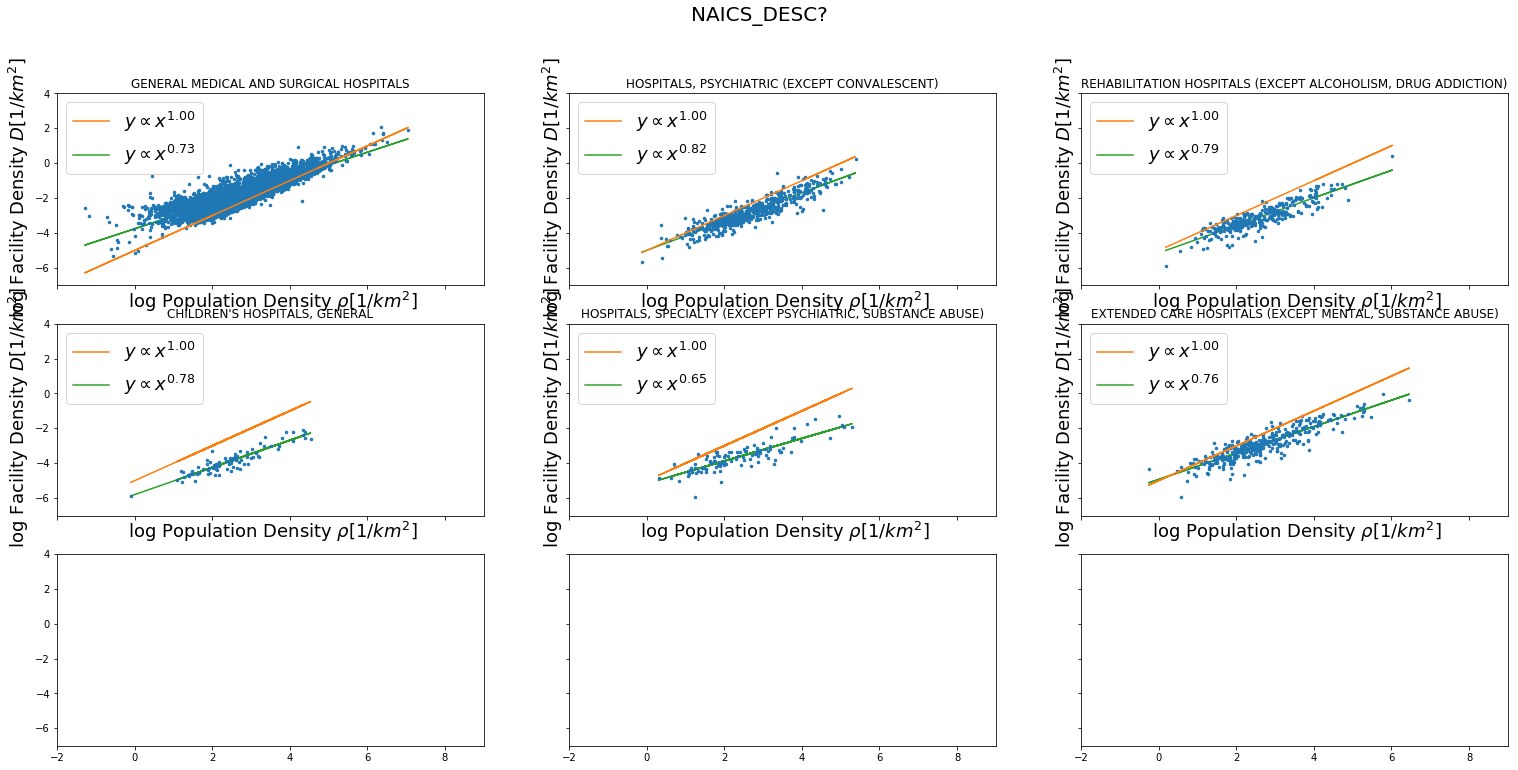

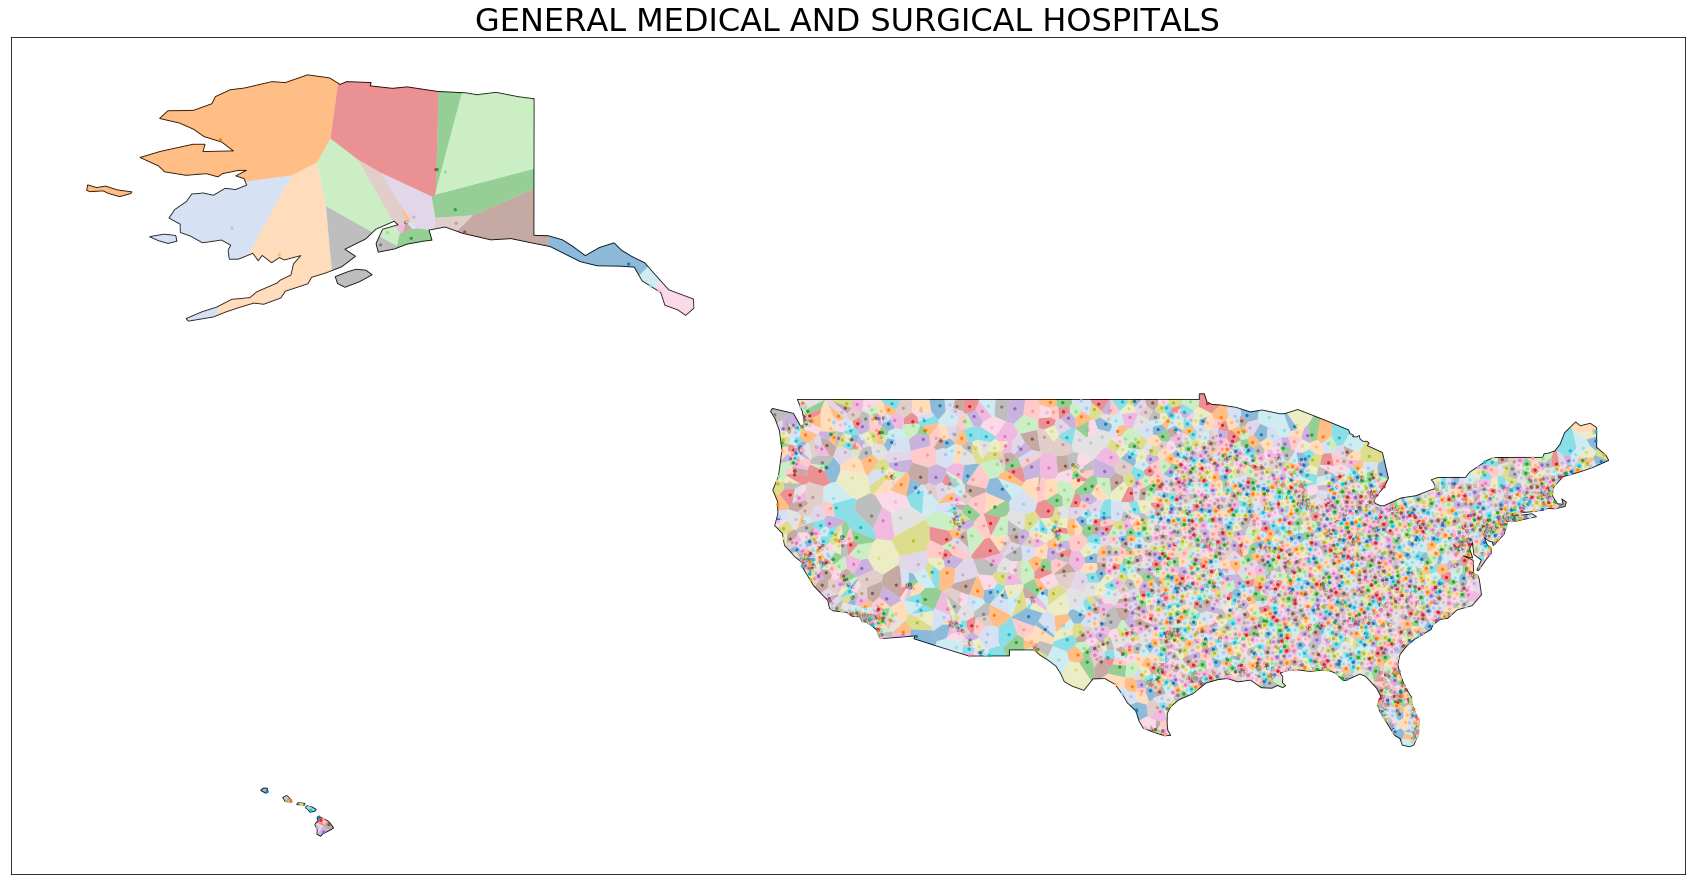

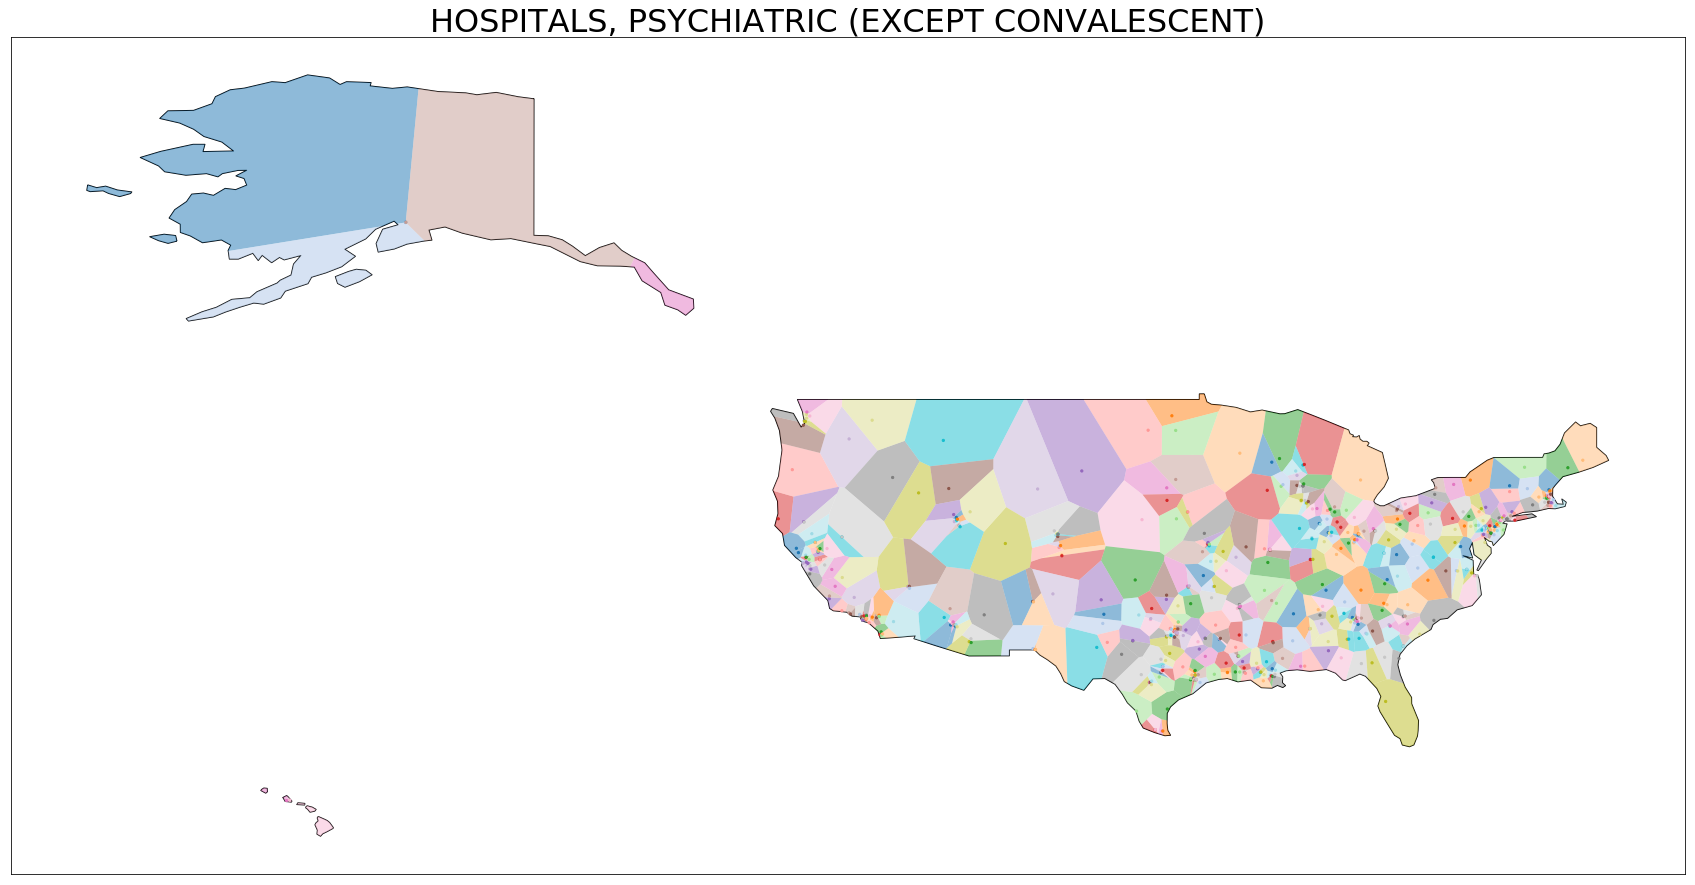

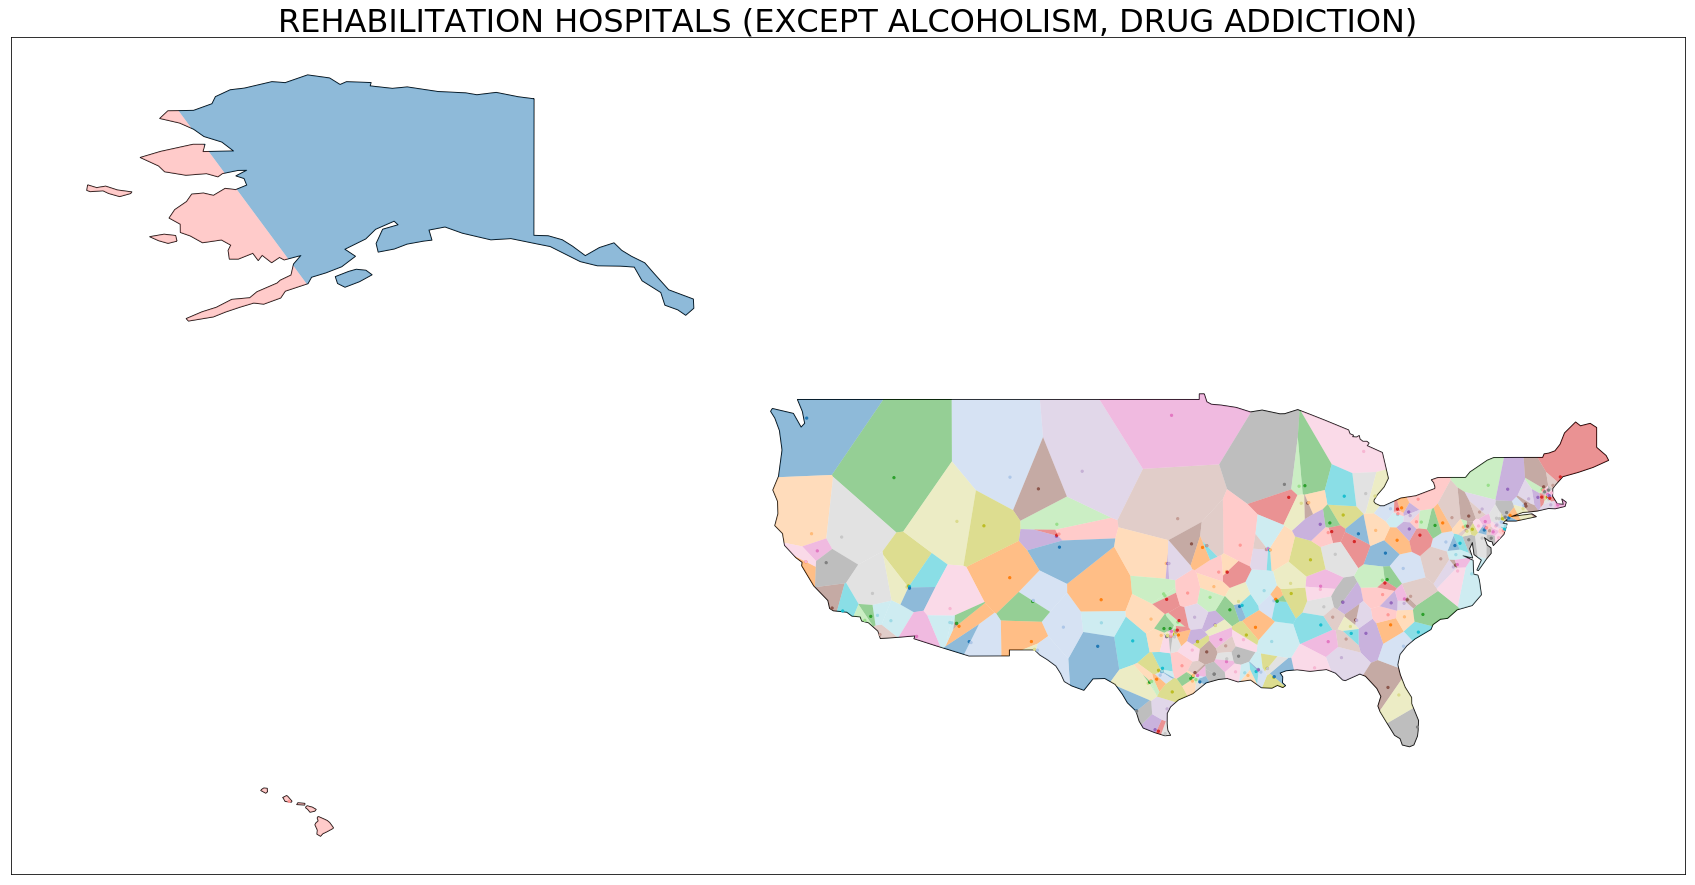

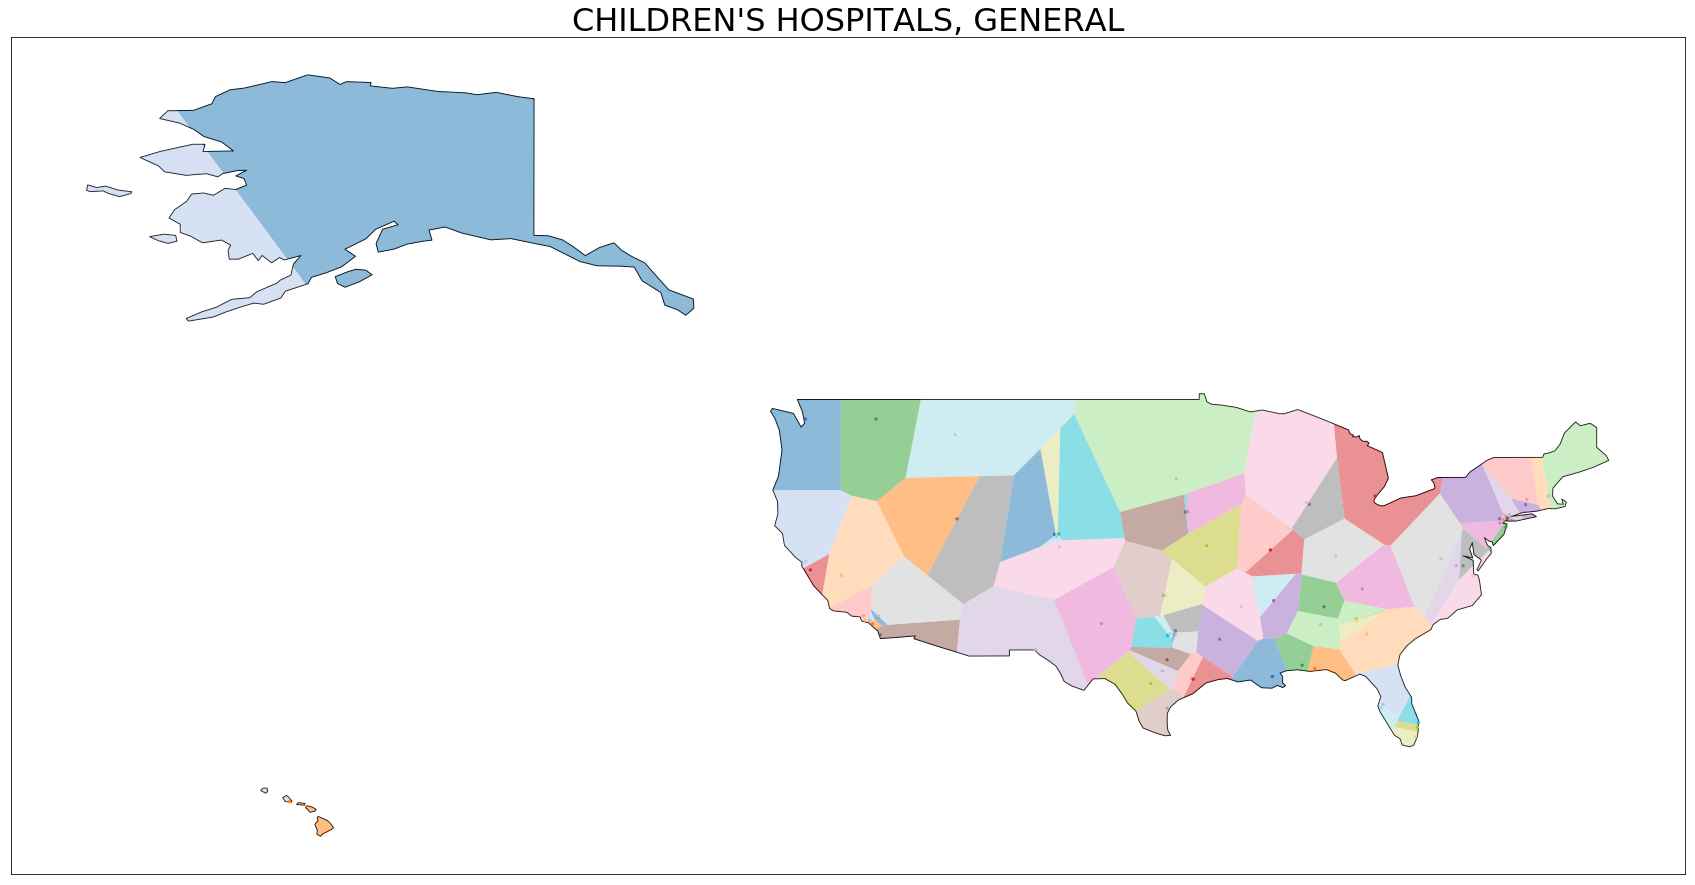

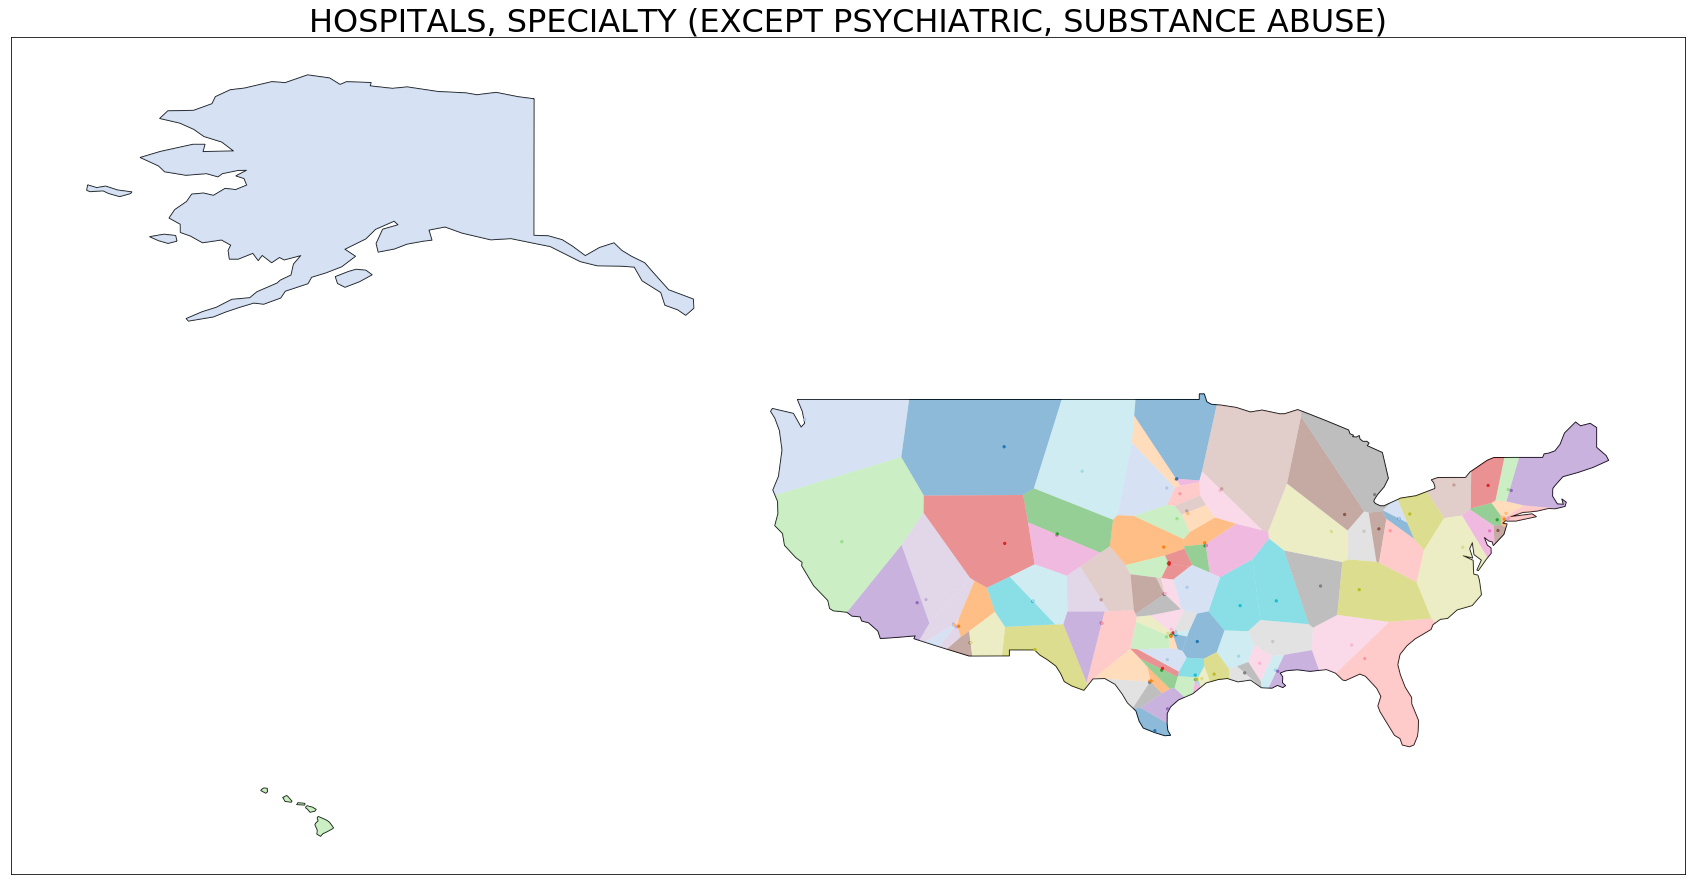

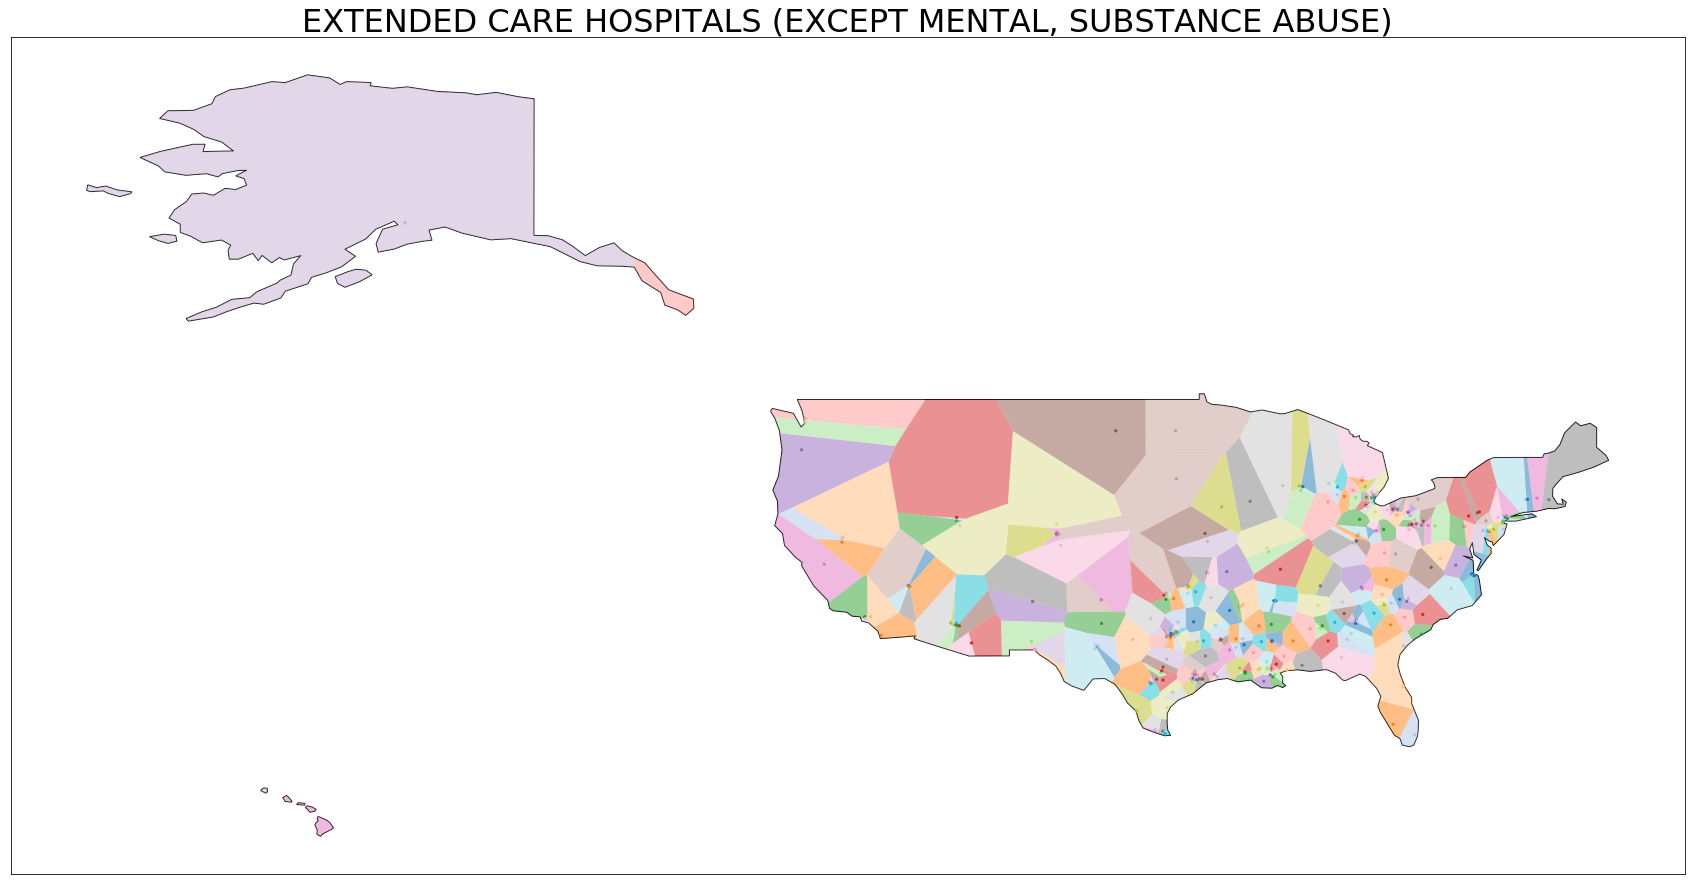

In [14]:
numplots =len(options)
numplots =6
print(numplots)
columns =3
fig,ax = plt.subplots(numplots//columns+1,columns, sharex=True, sharey=True,figsize = (26,6*numplots//columns))
ax=ax.ravel()
title=["SPECIALITY","PSYCHIATRIC AND SUBSTANCE","GENERAL"]
#hospitals = hospitals[hospitals['HELIPAD']=="N"]
count = 0
for i,x in enumerate(options):
    hospital = hospitals[hospitals[option_key]==x]
    print(x)
    try:
        plot_scaling(hospital,data,ax[count],x)
        count += 1
    except:
        pass
fig.suptitle(option_key+"?",fontsize=20)
plt.show()